### Counterfactual explanation on MNIST (PyTorch)

This is an example of `CounterfactualExplainer` on MNIST with a PyTorch model. `CounterfactualExplainer` is an optimization based method for generating counterfactual examples, supporting classification tasks only. If using this explainer, please cite the paper "Counterfactual Explanations without Opening the Black Box: Automated Decisions and the GDPR, Sandra Wachter, Brent Mittelstadt, Chris Russell, https://arxiv.org/abs/1711.00399".

In [1]:
# This default renderer is used for sphinx docs only. Please delete this cell in IPython.
import plotly.io as pio
pio.renderers.default = "png"

In [2]:
import torch
import torch.nn as nn
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import Dataset
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
from omnixai.data.image import Image

The model is a simple convolutional neural network with two convolutional layers and one dense hidden layer.

In [3]:
class InputData(Dataset):

    def __init__(self, images, labels):
        self.images = images
        self.labels = labels

    def __len__(self):
        return self.images.shape[0]

    def __getitem__(self, index):
        return self.images[index], self.labels[index]


class MNISTNet(nn.Module):

    def __init__(self):
        super().__init__()
        self.conv_layers = nn.Sequential(
            nn.Conv2d(1, 10, kernel_size=5),
            nn.MaxPool2d(2),
            nn.ReLU(),
            nn.Conv2d(10, 20, kernel_size=5),
            nn.Dropout(),
            nn.MaxPool2d(2),
            nn.ReLU(),
        )
        self.fc_layers = nn.Sequential(
            nn.Linear(320, 50),
            nn.ReLU(),
            nn.Dropout(),
            nn.Linear(50, 10)
        )

    def forward(self, x):
        x = self.conv_layers(x)
        x = torch.flatten(x, 1)
        x = self.fc_layers(x)
        return x

The following code loads the training and test datasets. We recommend using `Image` to represent a batch of images. `Image` can be constructed from a numpy array or a Pillow image. In this example, `Image` is constructed from a numpy array containing a batch of digit images.

In [4]:
# Load the training and test datasets
train_data = torchvision.datasets.MNIST(root='../data', train=True, download=True)
test_data = torchvision.datasets.MNIST(root='../data', train=False, download=True)
train_data.data = train_data.data.numpy()
test_data.data = test_data.data.numpy()

class_names = (0, 1, 2, 3, 4, 5, 6, 7, 8, 9)
# Use `Image` objects to represent the training and test datasets
x_train, y_train = Image(train_data.data, batched=True), train_data.targets
x_test, y_test = Image(test_data.data, batched=True), test_data.targets

The preprocessing function takes an `Image` instance as its input and outputs the processed features that the ML model consumes. In this example, the `Image` object is converted into a torch tensor via the defined `transform`.

In [5]:
device = "cuda" if torch.cuda.is_available() else "cpu"
# Build the CNN model
model = MNISTNet().to(device)
# The preprocessing function
transform = transforms.Compose([transforms.ToTensor()])
preprocess = lambda ims: torch.stack([transform(im.to_pil()) for im in ims])

We now train the CNN model defined above and evaluate its performance.

In [6]:
learning_rate=1e-3
batch_size=128
num_epochs=10

train_loader = DataLoader(
    dataset=InputData(preprocess(x_train), y_train),
    batch_size=batch_size,
    shuffle=True
)
test_loader = DataLoader(
    dataset=InputData(preprocess(x_test), y_test),
    batch_size=batch_size,
    shuffle=False
)
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
loss_func = nn.CrossEntropyLoss()

model.train()
for epoch in range(num_epochs):
    for i, (x, y) in enumerate(train_loader):
        x, y = x.to(device), y.to(device)
        loss = loss_func(model(x), y)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

correct_pred = {name: 0 for name in class_names}
total_pred = {name: 0 for name in class_names}

model.eval()
for x, y in test_loader:
    images, labels = x.to(device), y.to(device)
    outputs = model(images)
    _, predictions = torch.max(outputs, 1)
    for label, prediction in zip(labels, predictions):
        if label == prediction:
            correct_pred[class_names[label]] += 1
        total_pred[class_names[label]] += 1

for name, correct_count in correct_pred.items():
    accuracy = 100 * float(correct_count) / total_pred[name]
    print("Accuracy for class {} is: {:.1f} %".format(name, accuracy))

Accuracy for class 0 is: 99.7 %
Accuracy for class 1 is: 99.8 %
Accuracy for class 2 is: 99.3 %
Accuracy for class 3 is: 99.2 %
Accuracy for class 4 is: 99.5 %
Accuracy for class 5 is: 99.2 %
Accuracy for class 6 is: 98.6 %
Accuracy for class 7 is: 98.4 %
Accuracy for class 8 is: 99.2 %
Accuracy for class 9 is: 97.7 %


To initialize `CounterfactualExplainer`, we need to set the following parameters:
  
  - `model`: The ML model to explain, e.g., `torch.nn.Module` or `tf.keras.Model`.
  - `preprocess_function`: The preprocessing function that converts the raw data (a `Image` instance) into the inputs of `model`.
  - "optimization parameters": e.g., `binary_search_steps`, `num_iterations`. Please refer to the docs for more details.

In [7]:
from omnixai.explainers.vision import CounterfactualExplainer

explainer = CounterfactualExplainer(
    model=model,
    preprocess_function=preprocess
)

We can simply call `explainer.explain` to generate counterfactual examples for this classification task. `ipython_plot` plots the generated explanations in IPython. Parameter `index` indicates which instance to plot, e.g., `index = 0` means plotting the first instance in `x_test[0:5]`.

Binary step: 5 |███████████████████████████████████████-| 99.9% 

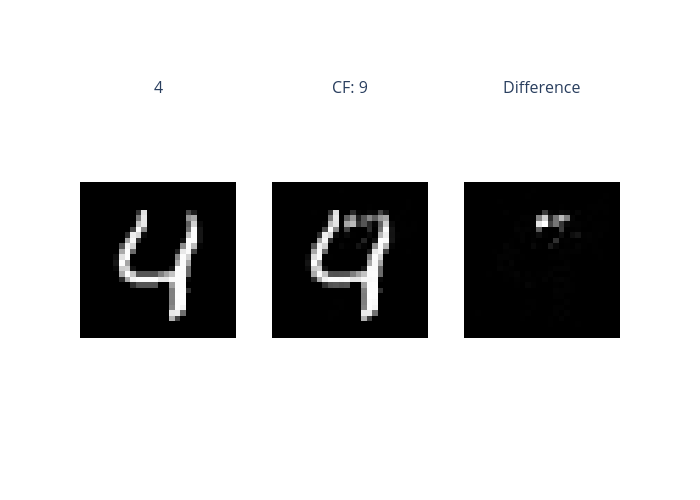

In [8]:
explanations = explainer.explain(x_test[0:5])
explanations.ipython_plot(index=4)